<a href="https://colab.research.google.com/github/Muzzamal-Hameed/Deep-Learning-Models/blob/main/Fish_Detection_using_CNN_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download -d crowww/a-large-scale-fish-dataset

100% 3.24G/3.24G [00:53<00:00, 34.6MB/s]
100% 3.24G/3.24G [00:53<00:00, 65.5MB/s]


In [8]:
! unzip a-large-scale-fish-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00435.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00436.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00437.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00438.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00439.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00440.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00441.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00442.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00443.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00444.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00445.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00446.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00447.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00448.png  
  inflating: Fish_Dataset/Fish_Dataset/

In [64]:
import numpy as np 
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.applications.resnet import preprocess_input
from keras_preprocessing.image import ImageDataGenerator
import os.path
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.metrics import classification_report
import inspect

In [65]:
import sys
dir = Path('/content/Fish_Dataset/Fish_Dataset')

# list of all filepathes
filepaths = list(dir.glob(r'**/*.png'))

# list of labels extracted from last foldername of filepath
labels = list(map(lambda l: os.path.split(os.path.split(l)[0])[1], filepaths))

# series of string filepathes
filepaths = pd.Series(filepaths, name='FilePaths').astype(str)

# series of string labels
labels = pd.Series(labels, name='Labels').astype(str)

# merge series to dataframe df
df = pd.merge(filepaths, labels, right_index=True, left_index=True)

# filter folders with GT (Ground Truth) at the end
df = df[df['Labels'].apply(lambda l: l[-2:] != 'GT')]

# resampling complete rows and reset the index
df = df.sample(frac=1).reset_index(drop=True)


In [66]:
df.head()

,FilePaths,Labels
0,/content/Fish_Dataset/Fish_Dataset/Hourse Mack...,Hourse Mackerel
1,/content/Fish_Dataset/Fish_Dataset/Red Mullet/...,Red Mullet
2,/content/Fish_Dataset/Fish_Dataset/Sea Bass/Se...,Sea Bass
3,/content/Fish_Dataset/Fish_Dataset/Black Sea S...,Black Sea Sprat
4,/content/Fish_Dataset/Fish_Dataset/Gilt-Head B...,Gilt-Head Bream


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FilePaths  9000 non-null   object
 1   Labels     9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


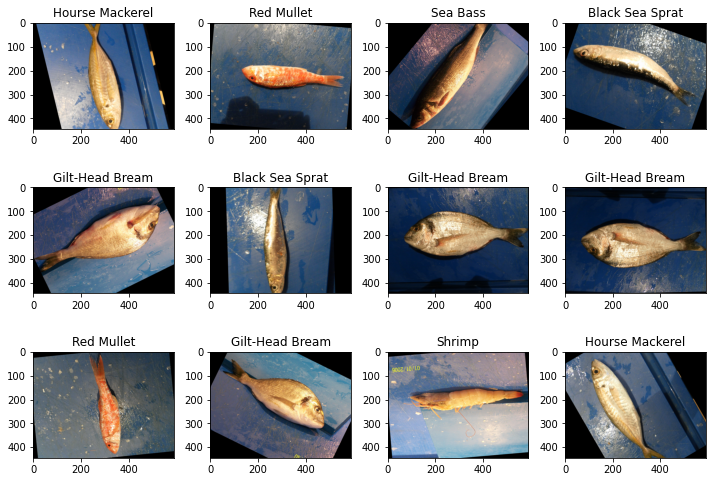

In [68]:
fit, ax = plt.subplots(nrows=3, ncols=4, figsize=(10, 7))

for i, a in enumerate(ax.flat):
    a.imshow(plt.imread(df.FilePaths[i]))
    a.set_title(df.Labels[i])
    
plt.tight_layout()
plt.show()

In [69]:
# stratisfied train and test (10%) datasets
X_train, X_test = train_test_split(df, test_size=0.1, stratify=df['Labels'])

print('Shape of Train Data: ', X_train.shape)
print('Shape of Test Data: ', X_test.shape)

# stratisfied train and val (20%) datasets
X_train, X_val = train_test_split(X_train, test_size=0.1, stratify=X_train['Labels'])

print('Shape of Train Data: ', X_train.shape)
print('Shape of Val Data: ', X_val.shape)

# ordered count of rows per unique label
X_train['Labels'].value_counts(ascending=True)

Shape of Train Data:  (8100, 2)
Shape of Test Data:  (900, 2)
Shape of Train Data:  (7290, 2)
Shape of Val Data:  (810, 2)


Striped Red Mullet    810
Red Sea Bream         810
Sea Bass              810
Shrimp                810
Red Mullet            810
Gilt-Head Bream       810
Black Sea Sprat       810
Hourse Mackerel       810
Trout                 810
Name: Labels, dtype: int64

In [70]:
# number of samples/images per iteration
BATCH_SIZE = 32
# input image size
IMG_SIZE = (75, 75)

# image preprocessing
img_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

X_train = img_data_gen.flow_from_dataframe(dataframe=X_train,
                                          x_col='FilePaths',
                                          y_col='Labels',
                                          target_size=IMG_SIZE,
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=BATCH_SIZE,
                                          seed=42)

X_val = img_data_gen.flow_from_dataframe(dataframe=X_val,
                                          x_col='FilePaths',
                                          y_col='Labels',
                                          target_size=IMG_SIZE,
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=BATCH_SIZE,
                                          seed=42)

X_test = img_data_gen.flow_from_dataframe(dataframe=X_test,
                                          x_col='FilePaths',
                                          y_col='Labels',
                                          target_size=IMG_SIZE,
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=BATCH_SIZE,
                                          seed=42)

Found 7290 validated image filenames belonging to 9 classes.
Found 810 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input dat

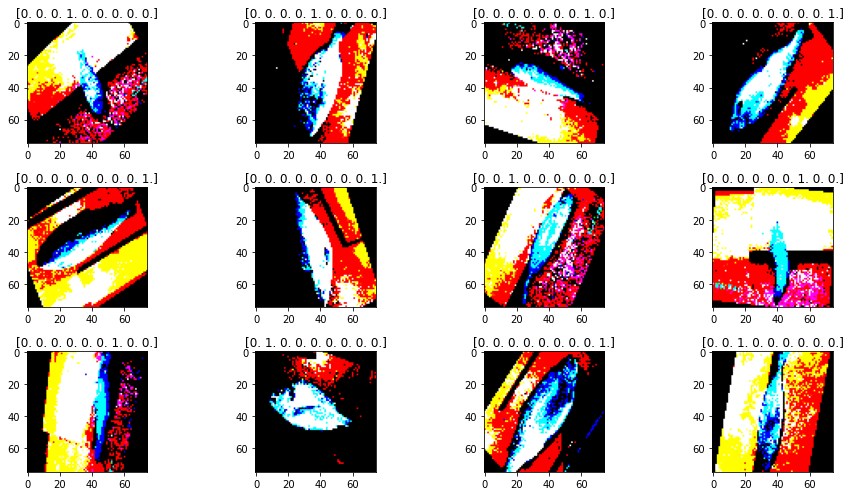

In [71]:
fit, ax = plt.subplots(nrows=3, ncols=4, figsize=(13,7))

for i, a in enumerate(ax.flat):
    img, label = X_train.next()
    a.imshow(img[0],)
    a.set_title(label[0])

plt.tight_layout()
plt.show()

In [72]:
model = Sequential()
# scale image values to 0..1
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255))

# 1. Conv2D layer
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# 2. Conv2D layer
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# 3. Conv2D layer
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# 4. Conv2D layer
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# scale to 1 dimensional input for NN
model.add(Flatten())

# hidden fully connected layer
model.add(Dense(512))
model.add(Activation('relu'))

# inhibit overfitting
model.add(Dropout(0.1))

# output fully connected layer
model.add(Dense(9))
model.add(Activation('softmax'))

# compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [87]:
# stop training when accuracy has stopped improving 
cb = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
# train model 
hst = model.fit(X_train, validation_data=X_val, epochs=5, callbacks=cb)

Epoch 1/5
228/228 [==============================] - 226s 991ms/step - loss: 0.6529 - accuracy: 0.7652 - val_loss: 0.2704 - val_accuracy: 0.9111
Epoch 2/5
228/228 [==============================] - 200s 875ms/step - loss: 0.2259 - accuracy: 0.9167 - val_loss: 0.2050 - val_accuracy: 0.9235
Epoch 3/5
228/228 [==============================] - 196s 860ms/step - loss: 0.1106 - accuracy: 0.9638 - val_loss: 0.1168 - val_accuracy: 0.9568
Epoch 4/5
228/228 [==============================] - 198s 865ms/step - loss: 0.0776 - accuracy: 0.9722 - val_loss: 0.0711 - val_accuracy: 0.9728
Epoch 5/5
228/228 [==============================] - 196s 859ms/step - loss: 0.0469 - accuracy: 0.9834 - val_loss: 0.0571 - val_accuracy: 0.9790


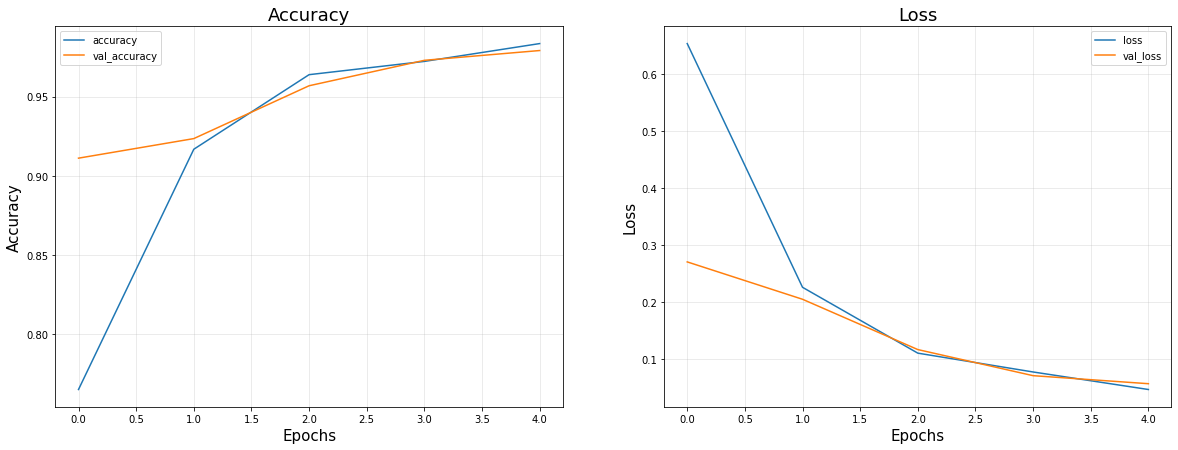

In [88]:
# Summarize the training process
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# Accuracy
plt.plot(hst.epoch, hst.history['accuracy'], label = "accuracy")
plt.plot(hst.epoch, hst.history['val_accuracy'], label = "val_accuracy")

plt.title("Accuracy", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


#Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(hst.epoch, hst.history['loss'], label="loss")
plt.plot(hst.epoch, hst.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [89]:
res = model.evaluate(X_test)

29/29 [==============================] - 15s 509ms/step - loss: 0.0683 - accuracy: 0.9778


In [90]:
print(f'Train Accuracy: {hst.history["accuracy"][-1:][0] * 100:.2f}')
print(f'Val Accuracy: {hst.history["val_accuracy"][-1:][0] * 100:.2f}')
print(f'Test Accuracy: {res[1] * 100:.2f}')

Train Accuracy: 98.34
Val Accuracy: 97.90
Test Accuracy: 97.78


In [ ]:
# # Map the label
# labels = (X_test.class_indices)
# labels = dict((v,k) for k,v in labels.items())
# res = [labels[k] for k in res]

# #
# cnn_model_test_acc = model.evaluate(X_test)[1]
# cnn_model_val_acc = model.evaluate(X_val)[1]

# #
# y_test = list(test_data.Label)
# print(classification_report(y_test, res))

In [91]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, None, None, None)  0         
                                                                 
 conv2d_498 (Conv2D)         (None, None, None, 32)    896       
                                                                 
 activation_482 (Activation)  (None, None, None, 32)   0         
                                                                 
 max_pooling2d_91 (MaxPoolin  (None, None, None, 32)   0         
 g2D)                                                            
                                                                 
 conv2d_499 (Conv2D)         (None, None, None, 64)    18496     
                                                                 
 activation_483 (Activation)  (None, None, None, 64)   0         
                                                      

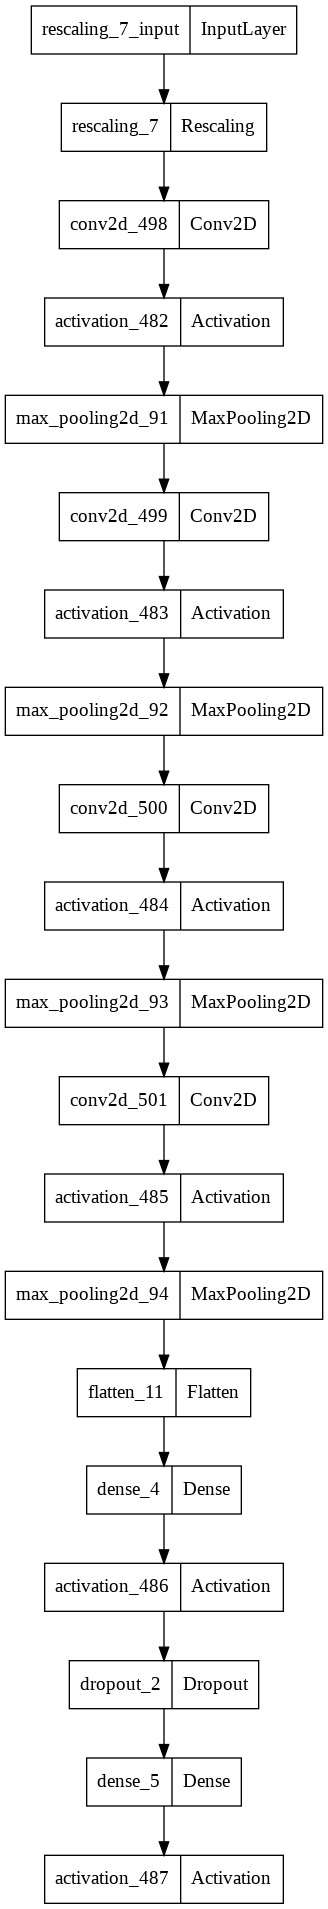

In [92]:
tf.keras.utils.plot_model(model)

In [93]:
model.save('fish_detection_model_v2.h5')

In [99]:
# from sklearn.metrics import confusion_matrix
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
    
    
# # Predict the values from the validation dataset
# Y_pred = model.predict(X_test)
# # Convert predictions classes to one hot vectors 
# Y_pred_classes = np.argmax(Y_pred,axis = 1) 

# y_test = model.predict(X_test)
# # Convert validation observations to one hot vectors
# Y_true = np.argmax(y_test,axis = 1) 
# # compute the confusion matrix
# confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# # plot the confusion matrix
# plot_confusion_matrix(confusion_mtx, classes = range(2))

In [73]:
INPUT_SHAPE = (75, 75, 3)
# VGG16
pretrained_model_VGG16 = tf.keras.applications.VGG16(
    input_shape=INPUT_SHAPE,
    include_top=False)

for layer in pretrained_model_VGG16.layers:
    layer.trainable = False
pretrained_model_VGG16.summary()
print('\n\n ---------------------------------------------------------------------------------------- \n\n')

# VGG19
pretrained_model_VGG19 = tf.keras.applications.VGG19(
    input_shape=INPUT_SHAPE,
    include_top=False)

for layer in pretrained_model_VGG19.layers:
    layer.trainable = False
pretrained_model_VGG19.summary()
print('\n\n ---------------------------------------------------------------------------------------- \n\n')

# ResNet50
pretrained_model_ResNet50 = tf.keras.applications.ResNet50V2(
    input_shape=INPUT_SHAPE,
    include_top=False)

for layer in pretrained_model_ResNet50.layers:
    layer.trainable = False
pretrained_model_ResNet50.summary()
print('\n\n ---------------------------------------------------------------------------------------- \n\n')

# ResNet101
pretrained_model_ResNet101 = tf.keras.applications.ResNet101V2(
    input_shape=INPUT_SHAPE,
    include_top=False)

for layer in pretrained_model_ResNet101.layers:
    layer.trainable = False
pretrained_model_ResNet101.summary()
print('\n\n ---------------------------------------------------------------------------------------- \n\n')

# ResNet152
pretrained_model_ResNet152 = tf.keras.applications.ResNet152V2(
    input_shape=INPUT_SHAPE,
    include_top=False)

for layer in pretrained_model_ResNet152.layers:
    layer.trainable = False
pretrained_model_ResNet152.summary()
print('\n\n ---------------------------------------------------------------------------------------- \n\n')

# DenseNet201
pretrained_model_DenseNet201 = tf.keras.applications.DenseNet201(
    input_shape=INPUT_SHAPE,
    include_top=False)

for layer in pretrained_model_DenseNet201.layers:
    layer.trainable = False
pretrained_model_DenseNet201.summary()
print('\n\n ---------------------------------------------------------------------------------------- \n\n')


# Inceptionv3
pretrained_model_Inceptionv3 = tf.keras.applications.InceptionV3(
    input_shape=INPUT_SHAPE,
    include_top=False)

for layer in pretrained_model_Inceptionv3.layers:
    layer.trainable = False
pretrained_model_Inceptionv3.summary()
print('\n\n ---------------------------------------------------------------------------------------- \n\n')

# EfficientNetB7
pretrained_model_EfficientNetB7 = tf.keras.applications.EfficientNetB7(
    input_shape=INPUT_SHAPE,
    include_top=False)

for layer in pretrained_model_EfficientNetB7.layers:
    layer.trainable = False
pretrained_model_EfficientNetB7.summary()
print('\n\n ---------------------------------------------------------------------------------------- \n\n')

# Xception
pretrained_model_Xception = tf.keras.applications.Xception(
    input_shape=INPUT_SHAPE,
    include_top=False)

for layer in pretrained_model_Xception.layers:
    layer.trainable = False
pretrained_model_Xception.summary()
print('\n\n ---------------------------------------------------------------------------------------- \n\n')


# MobileNetV2
pretrained_model_MobileNetV2 = tf.keras.applications.MobileNetV2(
    input_shape=INPUT_SHAPE,
    include_top=False,
    pooling='avg')

for layer in pretrained_model_MobileNetV2.layers:
    layer.trainable = False
pretrained_model_MobileNetV2.summary()
print('\n\n ---------------------------------------------------------------------------------------- \n\n')

Streaming output truncated to the last 5000 lines.
 lization)                                                                                        
                                                                                                  
 conv4_block14_0_relu (Activati  (None, 4, 4, 672)   0           ['conv4_block14_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block14_1_conv (Conv2D)  (None, 4, 4, 128)    86016       ['conv4_block14_0_relu[0][0]']   
                                                                                                  
 conv4_block14_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv4_block14_1_conv[0][0]']   
 lization)                                                                                        
                                                          

In [74]:
model_df = pd.DataFrame({'model_name': ['VGG16','VGG19', 'ResNet50', 'ResNet101', 'ResNet152', 'DenseNet201', 'Inceptionv3','EfficientNetB7', 'Xception', 'MobileNetV2'],
                         'model': [pretrained_model_VGG16,pretrained_model_VGG19, pretrained_model_ResNet50, pretrained_model_ResNet101,
                                    pretrained_model_ResNet152,pretrained_model_DenseNet201, pretrained_model_Inceptionv3,pretrained_model_EfficientNetB7, 
                                    pretrained_model_Xception, pretrained_model_MobileNetV2],
                         'val_acc': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
                         'test_acc': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]})
model_df

,model_name,model,val_acc,test_acc
0,VGG16,<keras.engine.functional.Functional object at ...,0.0,0.0
1,VGG19,<keras.engine.functional.Functional object at ...,0.0,0.0
2,ResNet50,<keras.engine.functional.Functional object at ...,0.0,0.0
3,ResNet101,<keras.engine.functional.Functional object at ...,0.0,0.0
4,ResNet152,<keras.engine.functional.Functional object at ...,0.0,0.0
5,DenseNet201,<keras.engine.functional.Functional object at ...,0.0,0.0
6,Inceptionv3,<keras.engine.functional.Functional object at ...,0.0,0.0
7,EfficientNetB7,<keras.engine.functional.Functional object at ...,0.0,0.0
8,Xception,<keras.engine.functional.Functional object at ...,0.0,0.0
9,MobileNetV2,<keras.engine.functional.Functional object at ...,0.0,0.0


In [75]:
NUM_DENSE_LAYERS = 2
NUM_NEURONS = [128,64]
DENSE_AF = 'relu'

In [76]:
# to keep track of the history of different models
history_dict = []

In [77]:

for i in range(model_df.shape[0]):
    print('------------------------------------------------------------')
    print(model_df['model_name'][i])
    print('------------------------------------------------------------')
    
    pretrained_model = model_df['model'][i]
    last_output_of_the_pretrained_model = pretrained_model.layers[-1].output
    x = tf.keras.layers.Flatten()(last_output_of_the_pretrained_model)

    for j in range(NUM_DENSE_LAYERS):
        x = tf.keras.layers.Dense(units = NUM_NEURONS[j], activation=DENSE_AF, name='dense_'+str(j+1))(x)

    output_layer = tf.keras.layers.Dense(units = 9, activation='softmax', name='output')(x)

    model_temp = tf.keras.Model(inputs=pretrained_model.input, outputs=output_layer)
    
    #
    optimizer = tf.keras.optimizers.Adam()

    #
    model_temp.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=["categorical_accuracy", "accuracy"])

    # train the model
    earlyStopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                              min_delta=0,
                                                              patience=3,
                                                              verbose=1) 

    history = model_temp.fit(x=X_train, validation_data= X_val, epochs = 5, callbacks=earlyStopping_callback)
    
    test_acc = model_temp.evaluate(X_test)[1]
    val_acc = model_temp.evaluate(X_val)[1]
    
    model_df['test_acc'][i] = test_acc
    model_df['val_acc'][i] = val_acc
    
    #
    history_dict.append(history)

------------------------------------------------------------
VGG16
------------------------------------------------------------
Epoch 1/5
228/228 [==============================] - 484s 2s/step - loss: 1.0836 - categorical_accuracy: 0.7716 - accuracy: 0.7716 - val_loss: 0.3755 - val_categorical_accuracy: 0.8778 - val_accuracy: 0.8778
Epoch 2/5
228/228 [==============================] - 480s 2s/step - loss: 0.1410 - categorical_accuracy: 0.9532 - accuracy: 0.9532 - val_loss: 0.2154 - val_categorical_accuracy: 0.9333 - val_accuracy: 0.9333
Epoch 3/5
228/228 [==============================] - 482s 2s/step - loss: 0.0729 - categorical_accuracy: 0.9770 - accuracy: 0.9770 - val_loss: 0.2317 - val_categorical_accuracy: 0.9309 - val_accuracy: 0.9309
Epoch 4/5
228/228 [==============================] - 482s 2s/step - loss: 0.0572 - categorical_accuracy: 0.9824 - accuracy: 0.9824 - val_loss: 0.1245 - val_categorical_accuracy: 0.9667 - val_accuracy: 0.9667
Epoch 5/5
26/26 [=======================

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


------------------------------------------------------------
VGG19
------------------------------------------------------------
Epoch 1/5
228/228 [==============================] - 587s 3s/step - loss: 0.9731 - categorical_accuracy: 0.7745 - accuracy: 0.7745 - val_loss: 0.5347 - val_categorical_accuracy: 0.8481 - val_accuracy: 0.8481
Epoch 2/5
228/228 [==============================] - 585s 3s/step - loss: 0.1639 - categorical_accuracy: 0.9422 - accuracy: 0.9422 - val_loss: 0.2618 - val_categorical_accuracy: 0.9111 - val_accuracy: 0.9111
Epoch 3/5
228/228 [==============================] - 585s 3s/step - loss: 0.0749 - categorical_accuracy: 0.9748 - accuracy: 0.9748 - val_loss: 0.1838 - val_categorical_accuracy: 0.9531 - val_accuracy: 0.9531
Epoch 4/5
228/228 [==============================] - 585s 3s/step - loss: 0.0466 - categorical_accuracy: 0.9846 - accuracy: 0.9846 - val_loss: 0.2328 - val_categorical_accuracy: 0.9432 - val_accuracy: 0.9432
Epoch 5/5
26/26 [=======================

In [78]:
print('Best Model:\n')
model_df.sort_values(by=["test_acc"], ascending=False).iloc[0, :]

Best Model:



model_name                                                VGG16
model         <keras.engine.functional.Functional object at ...
val_acc                                                0.965432
test_acc                                               0.943333
Name: 0, dtype: object

In [79]:
model_df.sort_values(by=["test_acc"], ascending=False)

,model_name,model,val_acc,test_acc
0,VGG16,<keras.engine.functional.Functional object at ...,0.965432,0.943333
1,VGG19,<keras.engine.functional.Functional object at ...,0.948148,0.938889
7,EfficientNetB7,<keras.engine.functional.Functional object at ...,0.896296,0.916667
5,DenseNet201,<keras.engine.functional.Functional object at ...,0.860494,0.866667
9,MobileNetV2,<keras.engine.functional.Functional object at ...,0.743210,0.761111
8,Xception,<keras.engine.functional.Functional object at ...,0.722222,0.711111
3,ResNet101,<keras.engine.functional.Functional object at ...,0.634568,0.644444
6,Inceptionv3,<keras.engine.functional.Functional object at ...,0.583951,0.624444
4,ResNet152,<keras.engine.functional.Functional object at ...,0.537037,0.558889
2,ResNet50,<keras.engine.functional.Functional object at ...,0.533333,0.533333


---------------------------------------
Pre-trained Model Histories
---------------------------------------



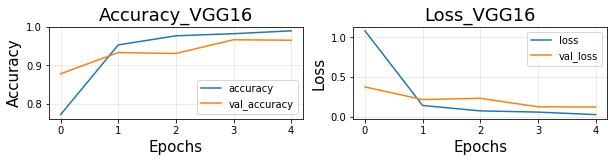

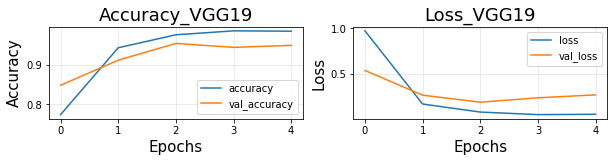

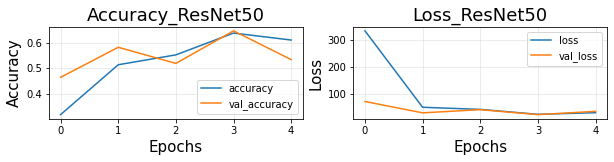

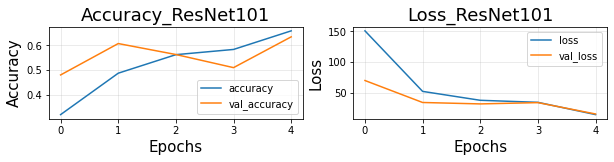

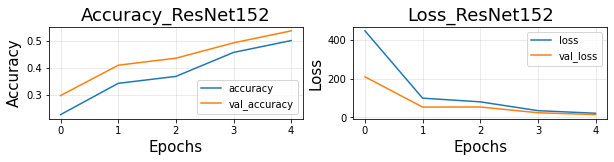

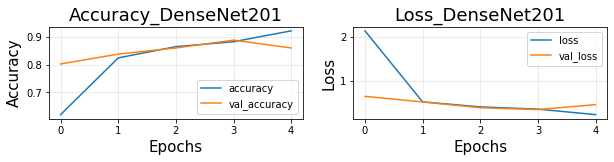

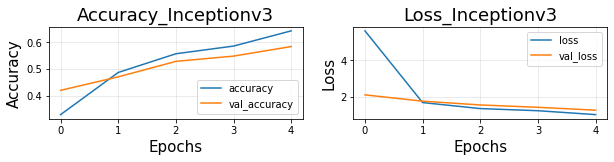

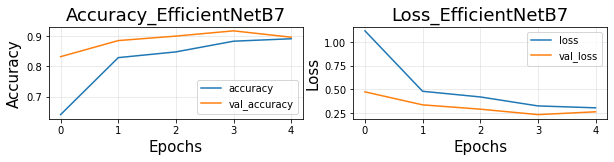

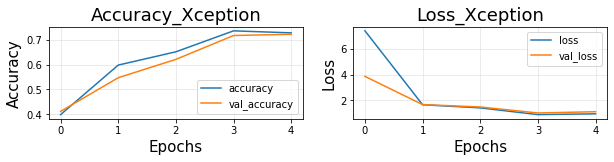

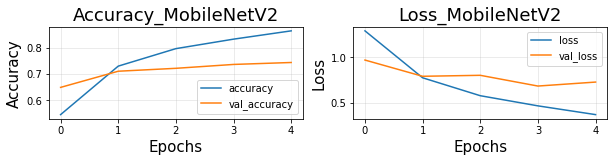

In [85]:
0.908889
#
print('---------------------------------------')
print('Pre-trained Model Histories')
print('---------------------------------------\n')

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 12,
        }

for i,j,k in [(0, 1, 2), (1, 3, 4), (2, 5, 6), (3, 7, 8), (4, 9, 10), (5, 11, 12),(6, 13, 14),(7, 15, 16),(8, 17, 18),(9, 19, 20)]:
    history_temp = history_dict[i]
    
    plt.figure(figsize=(10, 20))
    plt.subplot(10, 2, j)

    # Accuracy
    plt.plot(history_temp.epoch, history_temp.history['accuracy'], label = "accuracy")
    plt.plot(history_temp.epoch, history_temp.history['val_accuracy'], label = "val_accuracy")

    plt.title("Accuracy_"+model_df['model_name'][i], fontsize=18)
    plt.xlabel("Epochs", fontsize=15)
    plt.ylabel("Accuracy", fontsize=15)
    plt.grid(alpha=0.3)
    plt.legend()


    #Adding Subplot 1 (For Loss)
    plt.subplot(10, 2, k)

    plt.plot(history_temp.epoch, history_temp.history['loss'], label="loss")
    plt.plot(history_temp.epoch, history_temp.history['val_loss'], label="val_loss")

    plt.title("Loss_"+model_df['model_name'][i], fontsize=18)
    plt.xlabel("Epochs", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.grid(alpha=0.3)
    plt.legend()

    plt.show()

In [82]:
# for i in range(model_df.shape[0]):
#   a = history_dict[i]
#   a.save(model_df['model_name'][i])

In [100]:
cnn_model_test_acc = res[1]

print(f'{model_df.sort_values(by=["test_acc"], ascending=False).iloc[0, 0]} performed better among the pre-trained models with test accuracy equal to {round(model_df.sort_values(by=["test_acc"], ascending=False).iloc[0, 2], 4)}. Our CNN had test accuracy equal to {round(cnn_model_test_acc, 4)}.')

if cnn_model_test_acc>model_df.sort_values(by=["test_acc"], ascending=False).iloc[0, 2]:
    print('Therefore Our CNN has performed better.')
else:
    print(f'Therefore {model_df.sort_values(by=["test_acc"], ascending=False).iloc[0, 0]} has performed better.')

VGG16 performed better among the pre-trained models with test accuracy equal to 0.9654. Our CNN had test accuracy equal to 0.9778.
Therefore Our CNN has performed better.
